In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
%pip install --upgrade diffusers[torch] -q

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install -U peft

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.4/296.4 kB 2.0 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [14]:
%pip install -U autotrain-advanced

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 56.0 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.3/107.3 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.5/47.5 kB 2.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of datasets to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of datasets[vision] to determine which version is compatible with other requirements. This could take a while.
   ━━━━

In [ ]:
!autotrain dreambooth --train --model stabilityai/stable-diffusion-xl-base-1.0 --project-name stable --image-path /kaggle/input/Soumyajit/soumyajit --prompt "A photo of soumyajit wearing casual clothes and smiling." --resolution 1024 --batch-size 1 --num-steps 500 --gradient-accumulation 4 --lr 1e-4 --push-to-hub --token token --username soumyajit9979 --mixed-precision fp16

In [16]:
!autotrain dreambooth --h

usage: autotrain <command> [<args>] dreambooth [-h] [--train] [--deploy]
                                               [--inference]
                                               [--username USERNAME]
                                               [--backend {spaces-a10g-large,spaces-a10g-small,spaces-a100-large,spaces-t4-medium,spaces-t4-small,spaces-cpu-upgrade,spaces-cpu-basic,spaces-l4x1,spaces-l4x4,spaces-a10g-largex2,spaces-a10g-largex4,dgx-a100,dgx-2a100,dgx-4a100,dgx-8a100,ep-aws-useast1-s,ep-aws-useast1-m,ep-aws-useast1-l,ep-aws-useast1-xl,ep-aws-useast1-2xl,ep-aws-useast1-4xl,ep-aws-useast1-8xl,nvcf-l40sx1,nvcf-h100x1,nvcf-h100x2,nvcf-h100x4,nvcf-h100x8,local-ui,local,local-cli}]
                                               [--token TOKEN] [--push-to-hub]
                                               --model MODEL --project-name
                                               PROJECT_NAME
                                               [--data-path DATA_PATH]
             

In [17]:
!pip install huggingface_hub


In [ ]:
from huggingface_hub import HfApi, HfFolder, Repository

# Set your Hugging Face credentials
HfFolder.save_token("token")

# Define repository and local model directory
repo_id = "soumyajit9979/stable"
local_model_dir = "/kaggle/working/soumyajit9979-stable"

# Create repository object
repo = Repository(local_dir=local_model_dir, clone_from=repo_id)

# Add and push files to the repository
repo.git_add(auto_lfs_track=True)
repo.git_commit("Add fine-tuned model")
repo.git_push()


In [6]:
from diffusers import DiffusionPipeline, AutoencoderKL
import torch

# Load the VAE model
vae = AutoencoderKL.from_pretrained(
    "madebyollin/sdxl-vae-fp16-fix", 
    torch_dtype=torch.float16
)

# Load the base Stable Diffusion model
pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    vae=vae,
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True,
)

# Move the model to the GPU
pipe.to("cuda")

# Load the first set of LoRA weights
pipe.load_lora_weights("Soumyajit9979/stable", weight_name="pytorch_lora_weights.safetensors")

# Load the second set of LoRA weights
# pipe.load_lora_weights("ayushmangroliya15/VK", weight_name="pytorch_lora_weights.safetensors")

# Define the prompt
prompt = "soumyajit with messi, realistic, colorful, soothing"

# Generate images using the fine-tuned model
result = pipe(prompt=prompt, num_inference_steps=25, num_images_per_prompt=3)

# Extract and save the generated images
for i, img in enumerate(result.images):
    img.save(f"generated_image_{i}.png")


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

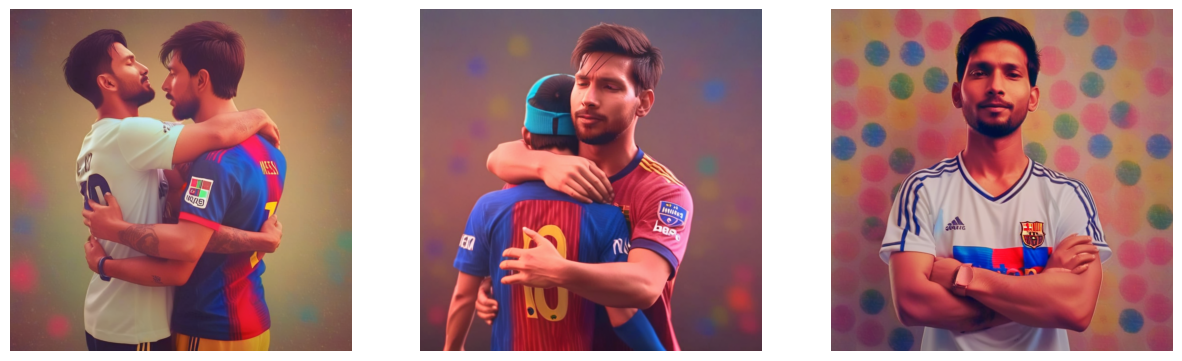

In [13]:
import matplotlib.pyplot as plt
import numpy as np


def show_images(image_tensor):
    images = image_tensor.images
    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    if num_images == 1:
        axes = [axes]
    for i, img in enumerate(images):
        if isinstance(img, torch.Tensor):
            img_np = img.cpu().numpy().transpose(1, 2, 0)  # Convert from tensor to NumPy array
        else:
            img_np = np.array(img)  # If not a tensor, assume it's already a NumPy array
        axes[i].imshow(img_np)
        axes[i].axis('off')
    plt.show()

# Show the generated images
show_images(image)